<a href="https://colab.research.google.com/github/linghduoduo/NLP/blob/master/Chap4_MLP_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
LABELS = [0, 0, 1, 1]
CENTERS = [(-3, -3), (3, 3), (3, -3), (-3, 3)]

MLPs are stacked Linear layers that map tensors to other tensors. Nonlinearities are used between each pair of Linear layers to break the linear relationship and allow for the model to twist the vector space around. In a classification setting, this twisting should result in linear separability between classes. Additionally, you can use the softmax function to interpret MLP outputs as probabilities.

In [ ]:
# Multilayer perceptron using PyTorch
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size=2, output_size=3, 
                 num_hidden_layers=1, hidden_activation=nn.Sigmoid):
        """Initialize weights.

        Args:
            input_size (int): size of the input 
            hidden_size (int): size of the hidden layers
            output_size (int): size of the output
            num_hidden_layers (int): number of hidden layers
            hidden_activation (torch.nn.*): the activation class
        """
        super(MultilayerPerceptron, self).__init__()
        self.module_list = nn.ModuleList()
        
        interim_input_size = input_size
        interim_output_size = hidden_size
        
        
        for _ in range(num_hidden_layers):
            self.module_list.append(nn.Linear(interim_input_size, interim_output_size))
            self.module_list.append(hidden_activation())
            interim_input_size = interim_output_size
            
        self.fc_final = nn.Linear(interim_input_size, output_size)
        
        self.last_forward_cache = []
       
    def forward(self, x, apply_softmax=False):
        """The forward pass of the MLP
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        self.last_forward_cache = []
        self.last_forward_cache.append(x.to("cpu").numpy())

        for module in self.module_list:
            x = module(x)
            self.last_forward_cache.append(x.to("cpu").data.numpy())
            
        output = self.fc_final(x)
        self.last_forward_cache.append(output.to("cpu").data.numpy())

        if apply_softmax:
            output = F.softmax(output, dim=1)
            
        return output

In [ ]:
batch_size = 2 # number of samples input at once
input_dim = 3
hidden_dim = 100
output_dim = 4

# Initialize model
mlp = MultilayerPerceptron(input_dim, hidden_dim, output_dim)
print(mlp)

MultilayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Sigmoid()
  )
  (fc_final): Linear(in_features=100, out_features=4, bias=True)
)


In [ ]:
def describe(x):
    print("Type: {}".format(x.type()))
    print("Shape/size: {}".format(x.shape))
    print("Values: \n{}".format(x))

x_input = torch.rand(batch_size, input_dim)
describe(x_input)

Type: torch.FloatTensor
Shape/size: torch.Size([2, 3])
Values: 
tensor([[0.0595, 0.7584, 0.6989],
        [0.9631, 0.9589, 0.8939]])


In [ ]:
y_output = mlp(x_input, apply_softmax=False)
describe(y_output)

Type: torch.FloatTensor
Shape/size: torch.Size([2, 4])
Values: 
tensor([[0.0544, 0.8214, 0.0159, 0.0589],
        [0.0473, 0.7878, 0.0216, 0.0798]], grad_fn=<AddmmBackward>)


In [ ]:
y_output = mlp(x_input, apply_softmax=True)
describe(y_output)

Type: torch.FloatTensor
Shape/size: torch.Size([2, 4])
Values: 
tensor([[0.1953, 0.4206, 0.1879, 0.1962],
        [0.1959, 0.4108, 0.1909, 0.2024]], grad_fn=<SoftmaxBackward>)


In [ ]:
## Get Data Function
def get_toy_data(batch_size):
    assert len(CENTERS) == len(LABELS), 'centers should have equal number labels'
    
    x_data = []
    y_targets = np.zeros(batch_size)
    n_centers = len(CENTERS)
    
    for batch_i in range(batch_size):
        center_idx = np.random.randint(0, n_centers)
        x_data.append(np.random.normal(loc=CENTERS[center_idx]))
        y_targets[batch_i] = LABELS[center_idx]
        
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.int64)

In [ ]:
## Visualizaing Results Function
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None, 
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    _, y_pred = perceptron(x_data, apply_softmax=True).max(dim=1)
    y_pred = y_pred.data.numpy()

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy()


    n_classes = len(set(LABELS))

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    colors = ['black', 'white']
    markers = ['o', '*']
    
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")
        #all_colors[y_true_i].append(colors[y_pred_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))
        
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=100)
    
        
    xlim = (min([x_list[:,0].min() for x_list in all_x]), 
            max([x_list[:,0].max() for x_list in all_x]))
            
    ylim = (min([x_list[:,1].min() for x_list in all_x]), 
            max([x_list[:,1].max() for x_list in all_x]))
            
    # hyperplane
    
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    for i in range(n_classes):
        Z = perceptron(torch.tensor(xy, dtype=torch.float32), 
                       apply_softmax=True)
        Z  = Z[:, i].data.numpy().reshape(XX.shape)
        ax.contour(XX, YY, Z, colors=colors[i], levels=levels, linestyles=linestyles)
    
    # plotting niceties
    
    plt.suptitle(title)
    
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

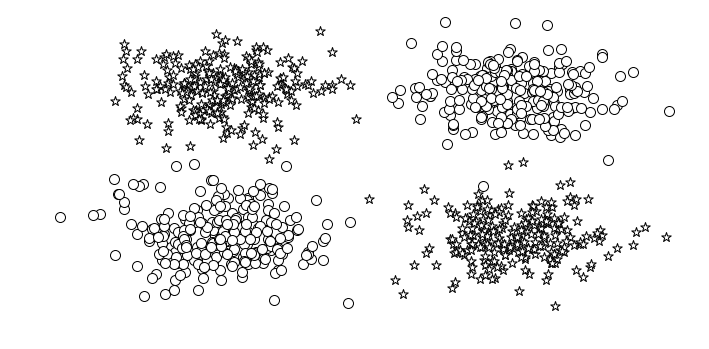

In [ ]:
## Initial Data Plot
seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

x_data, y_truth = get_toy_data(batch_size=1000)

x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy().astype(np.int64)

n_classes = len(set(LABELS))

all_x = [[] for _ in range(n_classes)]
all_colors = [[] for _ in range(n_classes)]

colors = ['black', 'white']
markers = ['o', '*']

for x_i, y_true_i in zip(x_data, y_truth):
    all_x[y_true_i].append(x_i)
    all_colors[y_true_i].append(colors[y_true_i])

all_x = [np.stack(x_list) for x_list in all_x]


_, ax = plt.subplots(1, 1, figsize=(10,5))

for x_list, color_list, marker in zip(all_x, all_colors, markers):
    ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor='black', marker=marker, facecolor="white", s=100)

plt.tight_layout()
plt.axis('off')

plt.title("");

plt.savefig("/Users/ling/Desktop/data.png")
plt.savefig("/Users/ling/Desktop/data.pdf")

MultilayerPerceptron(
  (module_list): ModuleList()
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


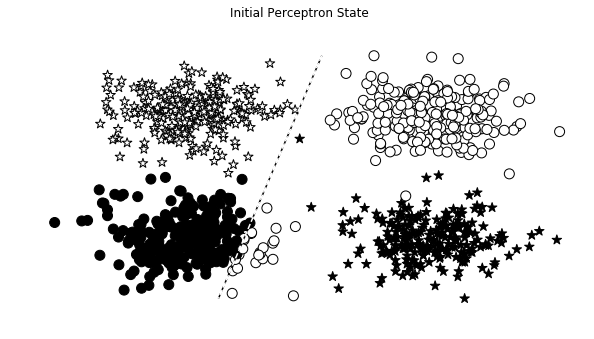

In [ ]:
## Training a Perceptron
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 0
hidden_size = 2 # isn't ever used but we still set it


seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp1 = MultilayerPerceptron(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_hidden_layers=num_hidden_layers, 
                            output_size=output_size)
print(mlp1)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp1, x_data_static, y_truth_static, 
                  ax=ax, title='Initial Perceptron State', levels=[0.5])

plt.axis('off')
plt.savefig('/Users/ling/Desktop/perceptron_initial.png')

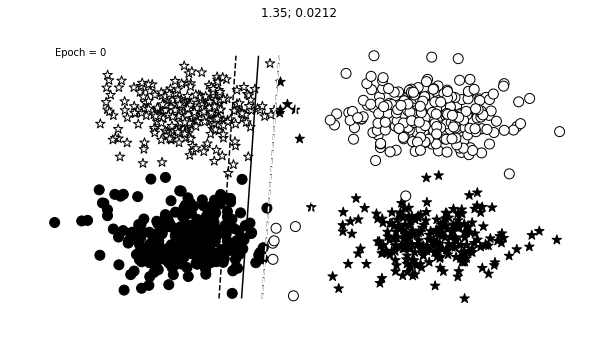

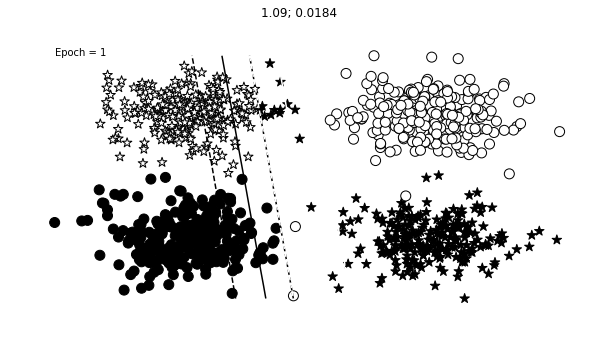

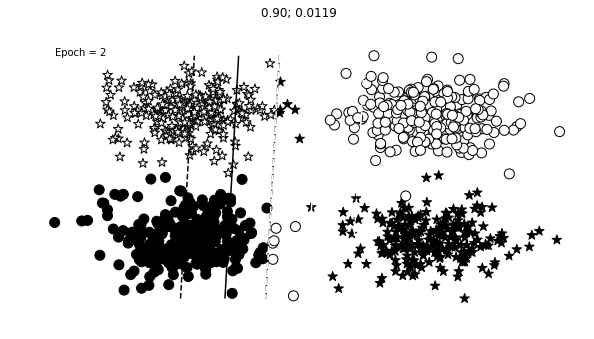

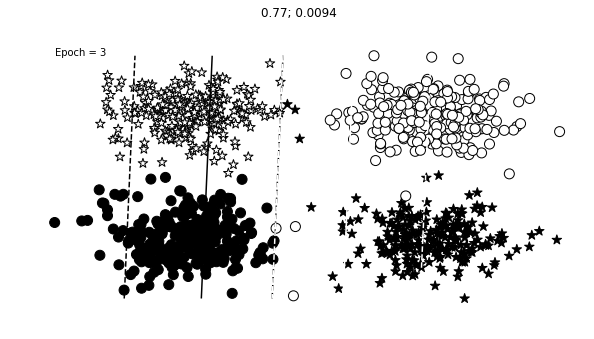

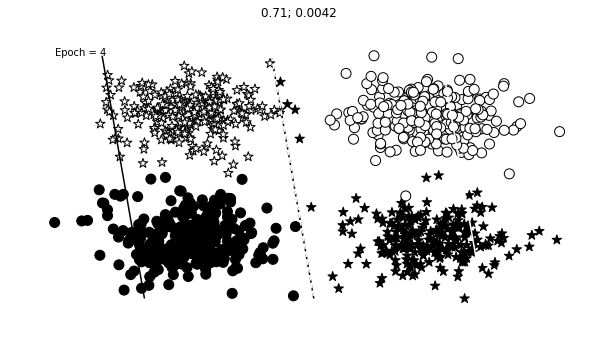

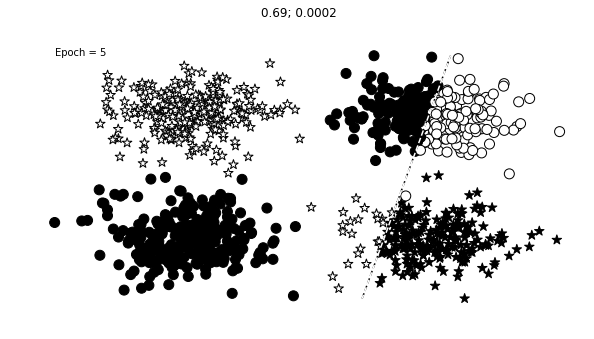

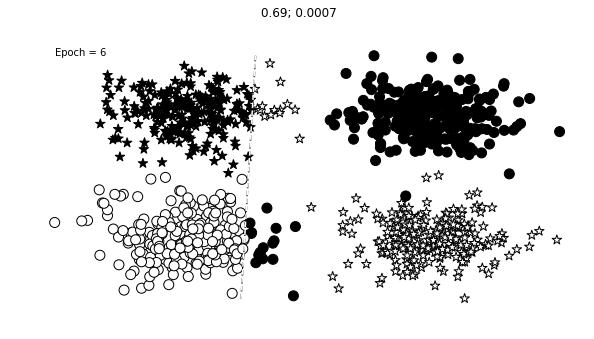

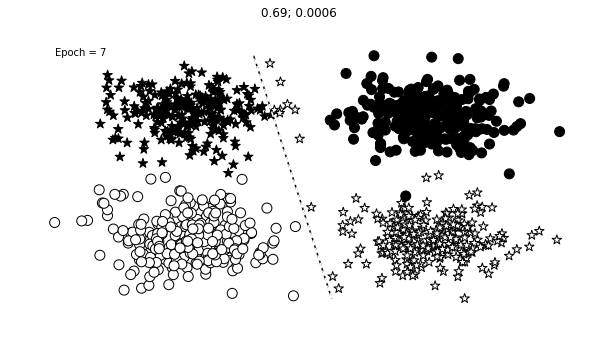

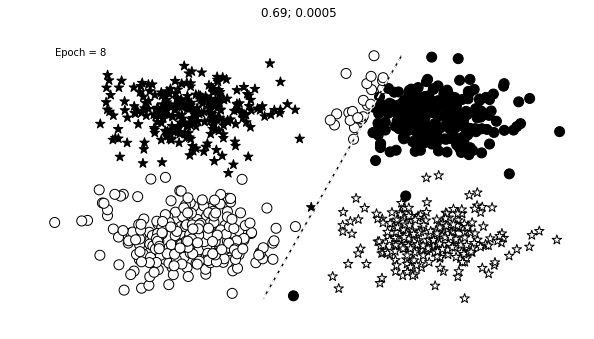

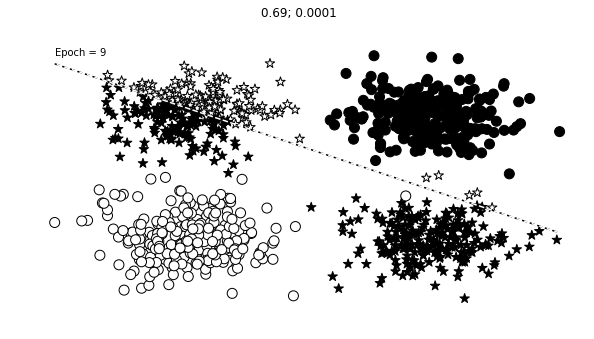

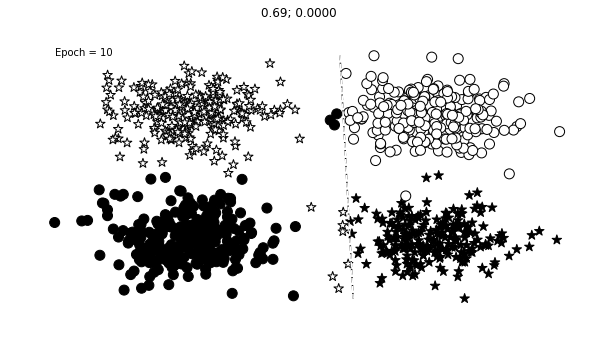

In [ ]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 10

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-3
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp1.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()

def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs = epoch > max_epochs
    
    #return terminate_for_loss_change or 
    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)
 
        # step 1: zero the gradients
        mlp1.zero_grad()
        
        # step 2: run the forward pass
        y_pred = mlp1(x_data).squeeze()
        
        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()
        
        # step 5: have the optimizer take an optimization step
        optimizer.step()
        
        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value
                
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(mlp1, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f"{loss_value:0.2f}; {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1
    all_imagefiles.append(f'/Users/ling/Desktop/perceptron_epoch{epoch}_toylearning.png')
    plt.savefig(all_imagefiles[-1])

MultilayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


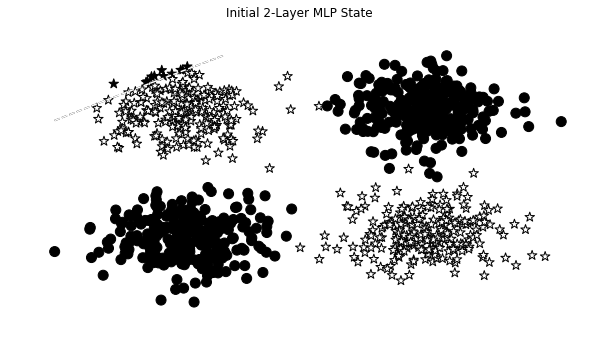

In [ ]:
## Training a 2 layer Multilayer Perceptron
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 1
hidden_size = 2

seed = 2

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp2 = MultilayerPerceptron(input_size=input_size, 
                           hidden_size=hidden_size, 
                           num_hidden_layers=num_hidden_layers, 
                           output_size=output_size)
print(mlp2)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp2, x_data_static, y_truth_static, 
                  ax=ax, title='Initial 2-Layer MLP State', levels=[0.5])

plt.axis('off')
plt.savefig('/Users/ling/Desktop/mlp2_initial.png');

/Users/ling/miniconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


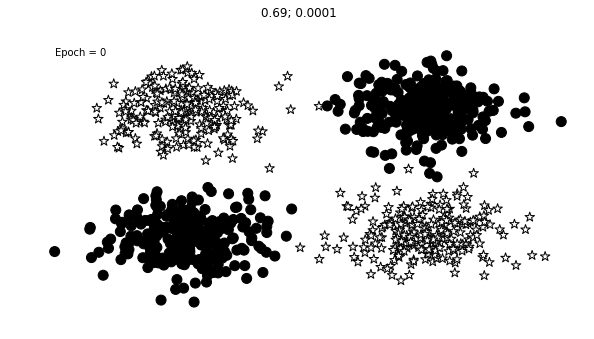

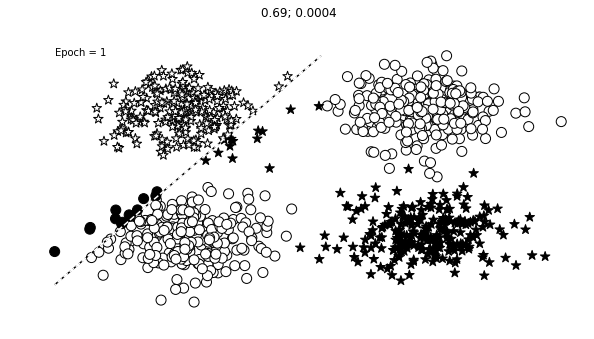

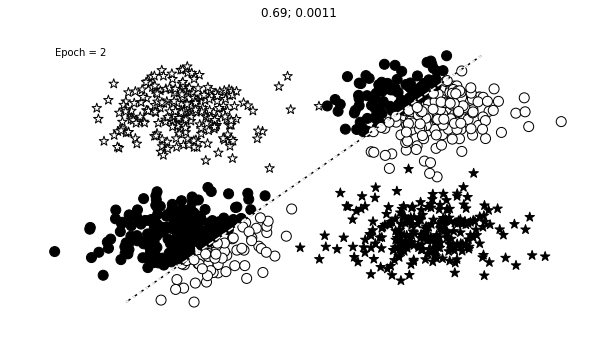

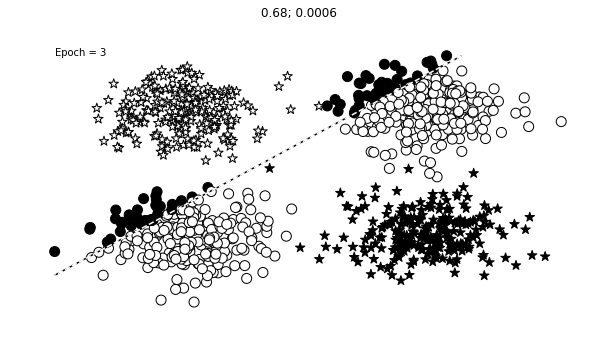

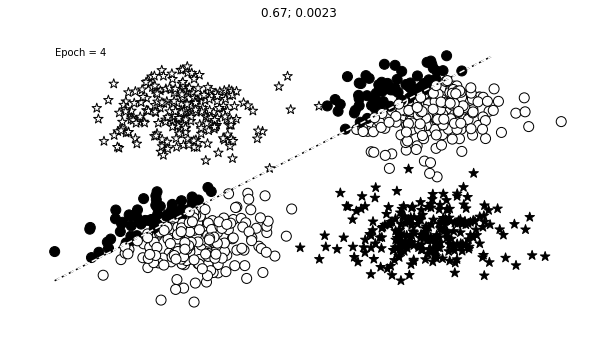

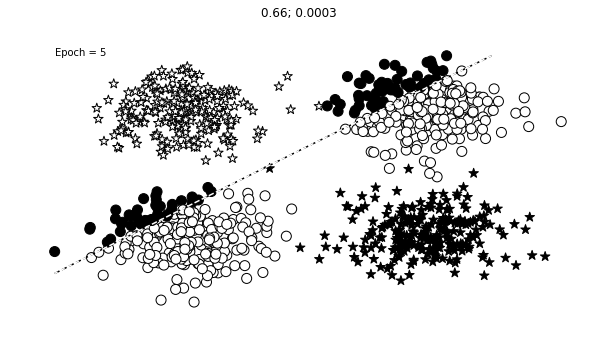

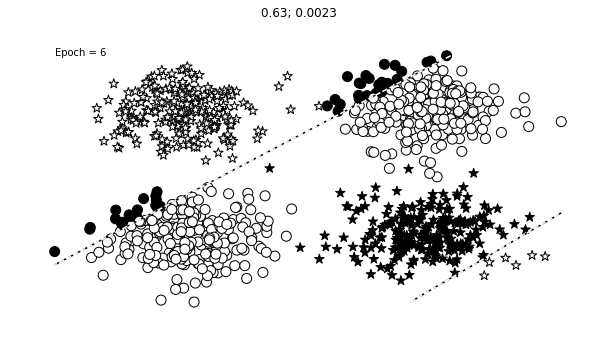

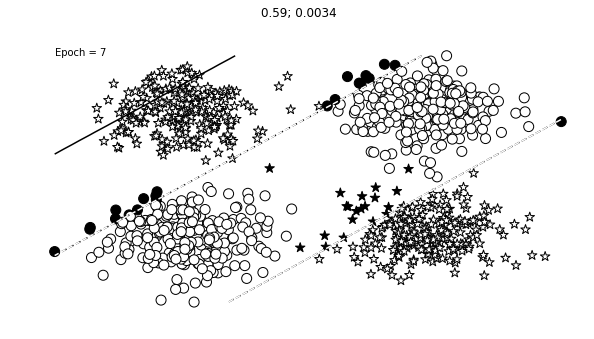

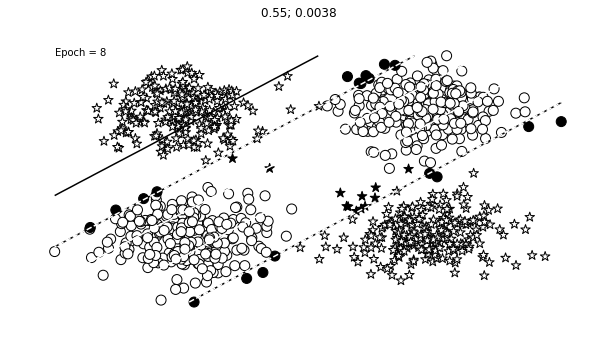

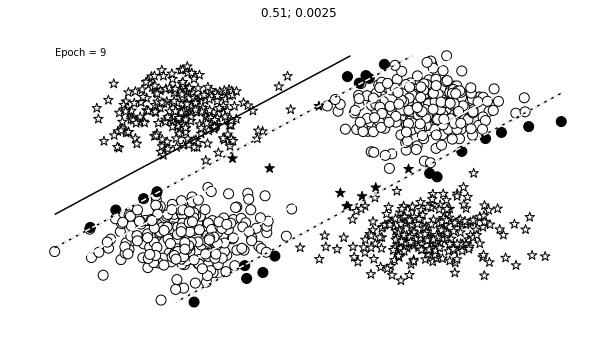

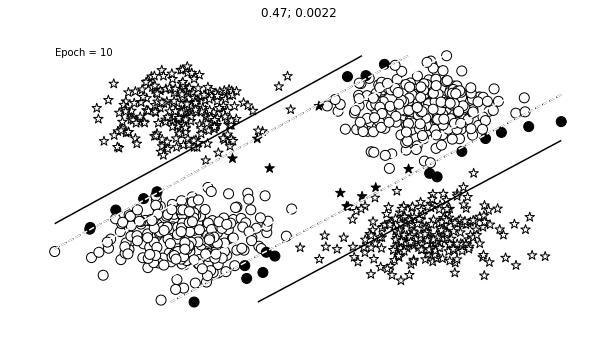

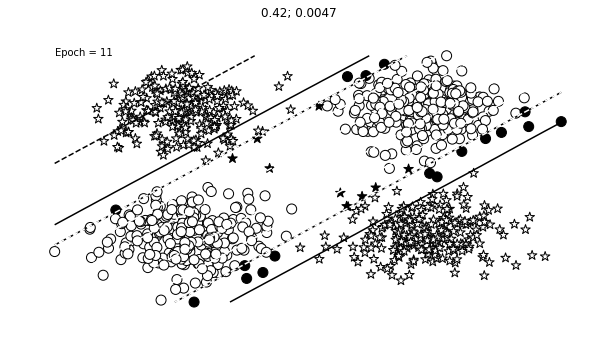

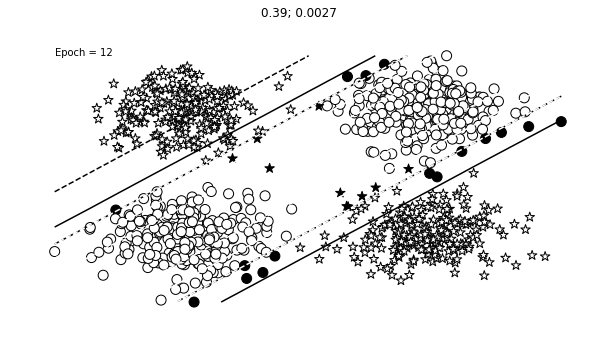

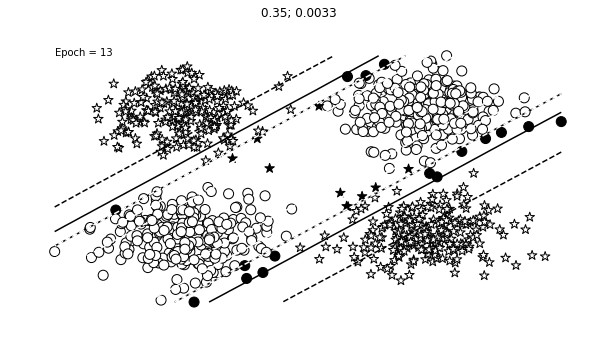

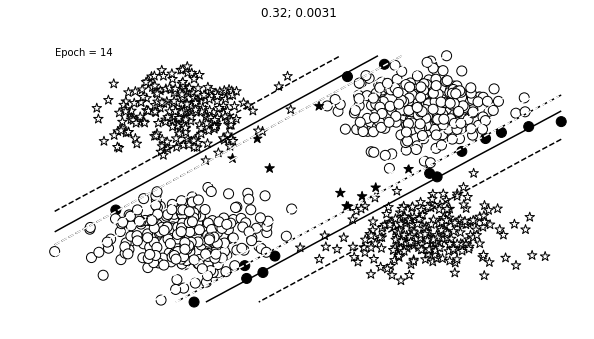

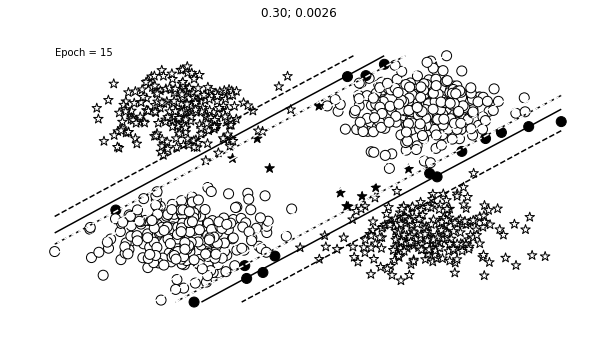

In [ ]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 15

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-5
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp2.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()

def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold    
    terminate_for_epochs = epoch > max_epochs
    
    #return terminate_for_loss_change or 
    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)
 
        # step 1: zero the gradients
        mlp2.zero_grad()
        
        # step 2: run the forward pass
        y_pred = mlp2(x_data).squeeze()
        
        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()
        
        # step 5: have the optimizer take an optimization step
        optimizer.step()
        
        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value
                
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(mlp2, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f"{loss_value:0.2f}; {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1
    all_imagefiles.append(f'/Users/ling/Desktop/mlp2_epoch{epoch}_toylearning.png')
    plt.savefig(all_imagefiles[-1])

MultilayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): Sigmoid()
  )
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


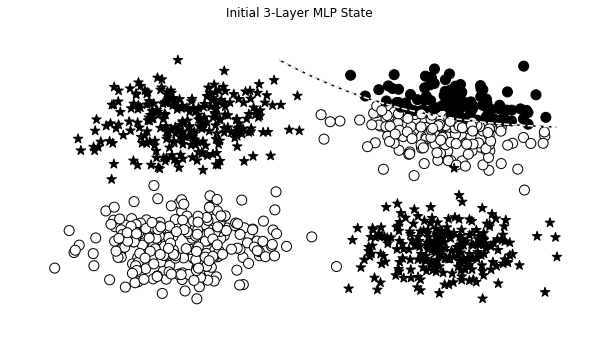

In [ ]:
## Training a 3 layer Multilayer Perceptron
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 2
hidden_size = 2

seed = 399

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp3 = MultilayerPerceptron(input_size=input_size, 
                           hidden_size=hidden_size, 
                           num_hidden_layers=num_hidden_layers, 
                           output_size=output_size)
print(mlp3)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp3, x_data_static, y_truth_static, 
                  ax=ax, title='Initial 3-Layer MLP State', levels=[0.5])

plt.axis('off')
plt.savefig('/Users/ling/Desktop/mlp3_initial.png');

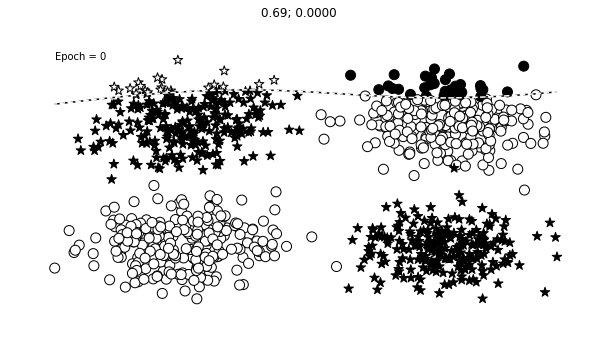

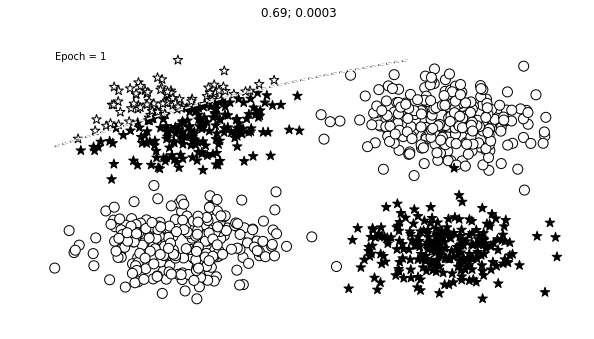

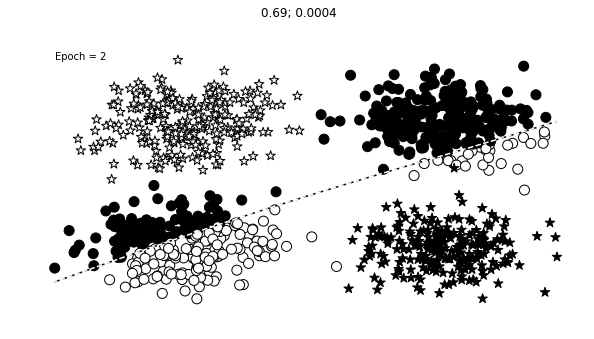

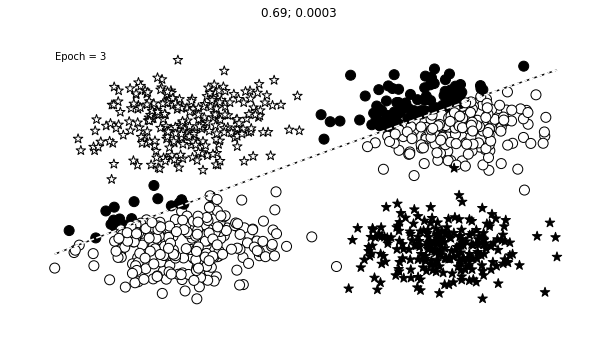

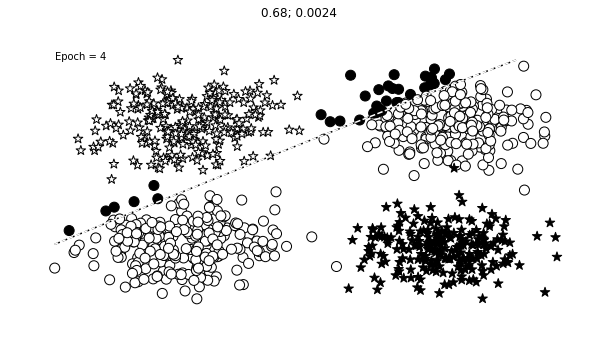

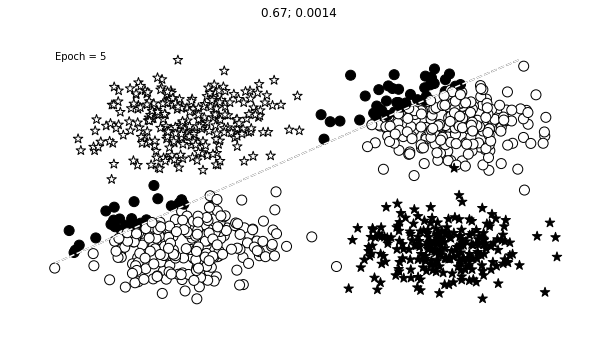

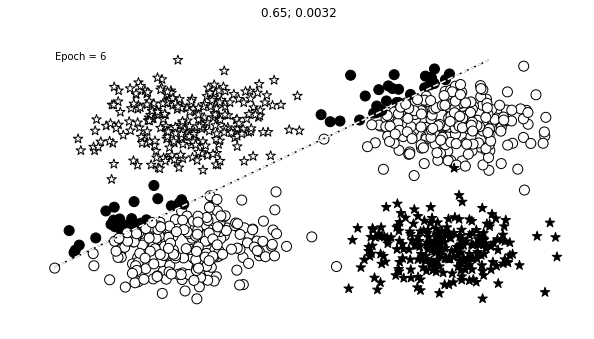

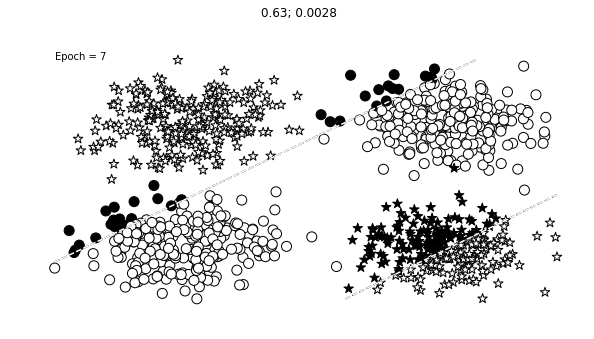

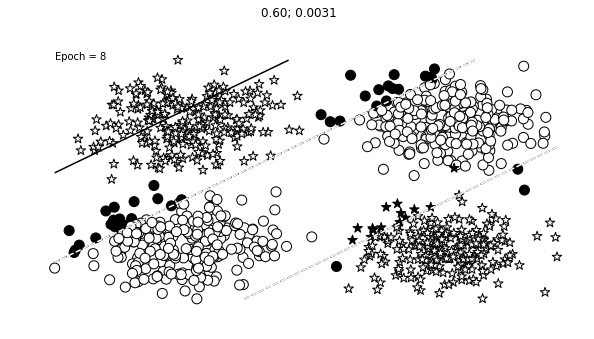

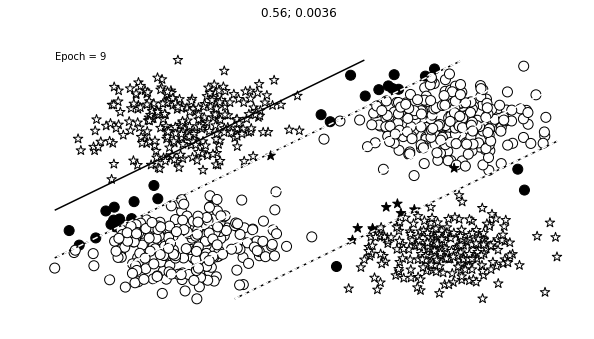

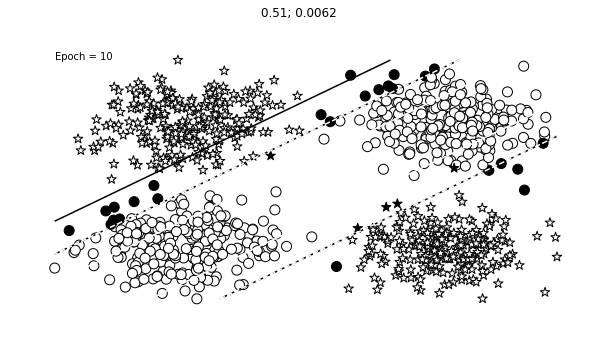

In [ ]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 10

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-5
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp3.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()

def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold    
    terminate_for_epochs = epoch > max_epochs
    
    #return terminate_for_loss_change or 
    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)
 
        # step 1: zero the gradients
        mlp3.zero_grad()
        
        # step 2: run the forward pass
        y_pred = mlp3(x_data).squeeze()
        
        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()
        
        # step 5: have the optimizer take an optimization step
        optimizer.step()
        
        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value
                
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(mlp3, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f"{loss_value:0.2f}; {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1
    all_imagefiles.append(f'/Users/ling/Desktop/mlp3_epoch{epoch}_toylearning.png')
    plt.savefig(all_imagefiles[-1])

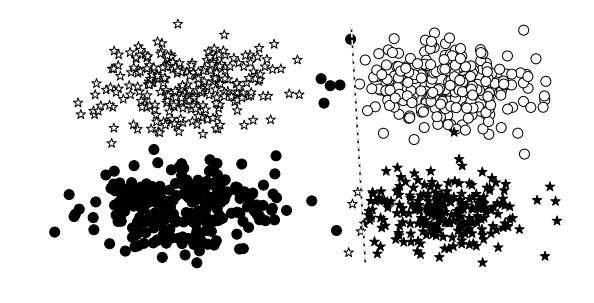

In [ ]:
_, ax = plt.subplots(1,1,figsize=(10,5))
visualize_results(mlp1, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=ax)
plt.axis('off');
plt.savefig('/Users/ling/Desktop/perceptron_final.png')


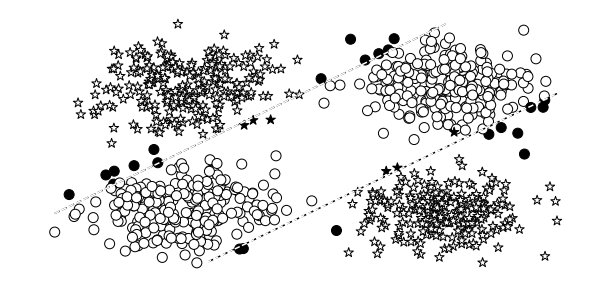

In [ ]:
_, ax = plt.subplots(1,1,figsize=(10,5))
visualize_results(mlp2, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=ax)
plt.axis('off');
plt.savefig('/Users/ling/Desktop/mlp2_final.png')

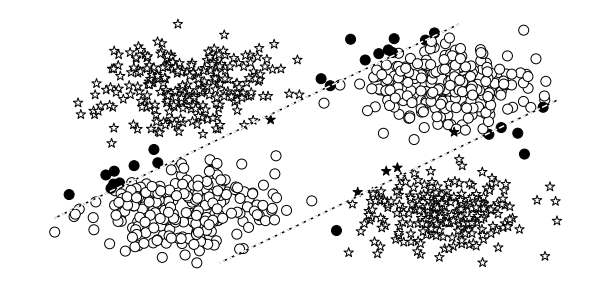

In [ ]:
_, ax = plt.subplots(1,1,figsize=(10,5))
visualize_results(mlp3, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=ax)
plt.axis('off');
plt.savefig('/Users/ling/Desktop/mlp3_final.png')


In [ ]:
## Inspecting the representations
batch_size = 100

def plot_intermediate_representations(mlp_model, plot_title, figsize=(10,2)):
    x_data, y_target = get_toy_data(batch_size)

    y_pred = mlp_model(x_data, True).detach().numpy()

    x_data = x_data.numpy()
    y_target = y_target.numpy()

    colors = ['black', 'white'] 
    markers = ['o', '*'] 

    #     plot_colors = []
    #     for i in range(y_target.shape[0]):
    #         plot_colors.append(colors[y_target[i]])

    plot_markers = []
    class_zero_indices = []
    class_one_indices = []
    for i in range(y_target.shape[0]):
        if y_target[i] == 0:
            class_zero_indices.append(i)
        else:
            class_one_indices.append(i)
    class_zero_indices = np.array(class_zero_indices)
    class_one_indices = np.array(class_one_indices)
    # plot_markers.append(markers[y_target[i]])

    fig, axes = plt.subplots(1, len(mlp_model.last_forward_cache), figsize=figsize)

    for class_index, data_indices in enumerate([class_zero_indices, class_one_indices]):

        axes[0].scatter(x_data[data_indices,0], x_data[data_indices,1], edgecolor='black', facecolor="white",
                            marker=markers[class_index], s=[200,400][class_index])
        axes[0].axis('off')
        for i, activations in enumerate(mlp_model.last_forward_cache[1:], 1):
            axes[i].scatter(activations[data_indices,0], activations[data_indices,1], edgecolor='black', facecolor="white",
                            marker=markers[class_index], s=[200,400][class_index])
            axes[i].axis('off')

    plt.tight_layout()

    plt.suptitle(plot_title, size=15)
    plt.subplots_adjust(top=0.75)

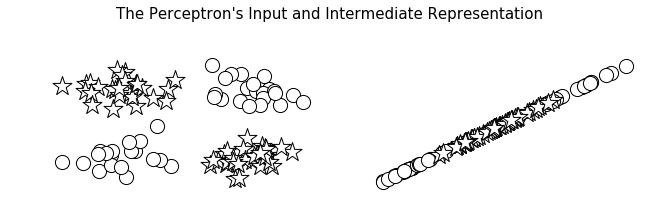

In [ ]:
plot_intermediate_representations(mlp1, 
                                  "The Perceptron's Input and Intermediate Representation",
                                  figsize=(9, 3))
plt.savefig("/Users/ling/Desktop/perceptron_intermediate.png")
plt.savefig("/Users/ling/Desktop/figure_4_5.pdf")


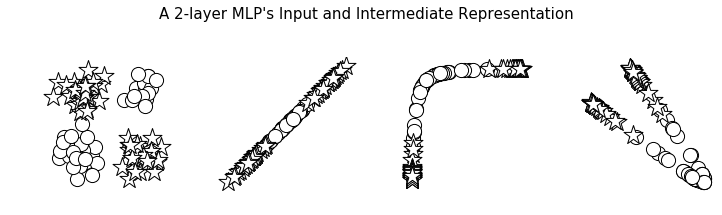

In [ ]:
plot_intermediate_representations(mlp2,
                                  "A 2-layer MLP's Input and Intermediate Representation",
                                  figsize=(10, 3))
plt.savefig("/Users/ling/Desktop/mlp2_intermediate.png")
plt.savefig("/Users/ling/Desktop/figure_4_4.pdf")

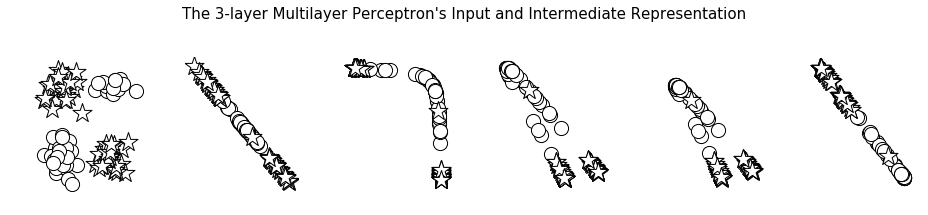

In [ ]:
plot_intermediate_representations(mlp3, 
                                  "The 3-layer Multilayer Perceptron's Input and Intermediate Representation",
                                  figsize=(13, 3))
plt.savefig("/Users/ling/Desktop/mlp3_intermediate.png")
plt.savefig("/Users/ling/Desktop//mlp3_intermediate.pdf")

## Suname Dataset

In [ ]:
import collections
import numpy as np
import pandas as pd
import re

from argparse import Namespace

In [ ]:
args = Namespace(
    raw_dataset_csv="/Users/ling/Desktop/Git/NLP/data/surnames/surnames_with_splits.csv",
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="data/surnames/surnames_with_splits.csv",
    seed=1337
)

In [ ]:
# Read raw data
surnames = pd.read_csv("/Users/ling/Desktop/Git/NLP/data/surnames/surnames_with_splits.csv", header=0)

In [ ]:
surnames.head()

nationality  nationality_index  split   surname
0      Arabic                 15  train     Totah
1      Arabic                 15  train    Abboud
2      Arabic                 15  train  Fakhoury
3      Arabic                 15  train     Srour
4      Arabic                 15  train    Sayegh

In [ ]:
# Unique classes
set(surnames.nationality)

{'Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese'}

In [ ]:
# Splitting train by nationality
# Create dict
by_nationality = collections.defaultdict(list)
for _, row in surnames.iterrows():
    by_nationality[row.nationality].append(row.to_dict())

In [ ]:
# Create split data
args = Namespace(
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    seed=1337
)

final_list = []
np.random.seed(args.seed)
for _, item_list in sorted(by_nationality.items()):
    np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_proportion*n)
    n_val = int(args.val_proportion*n)
    n_test = int(args.test_proportion*n)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  
    
    # Add to final list
    final_list.extend(item_list)

In [ ]:
# Write split data to file
final_surnames = pd.DataFrame(final_list)

In [ ]:
final_surnames.split.value_counts()

train    7680
test     1660
val      1640
Name: split, dtype: int64

In [ ]:
from argparse import Namespace
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [ ]:
## Vocabulary
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        try:
            index = self._token_to_idx[token]
        except KeyError:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [ ]:
## Implementing SurnameVectorizer
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab):
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname):
        """Vectorize the provided surname

        Args:
            surname (str): the surname
        Returns:
            one_hot (np.ndarray): a collapsed one-hot encoding
        """
        vocab = self.surname_vocab
        one_hot = np.zeros(len(vocab), dtype=np.float32)
        for token in surname:
            one_hot[vocab.lookup_token(token)] = 1
        return one_hot

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab = Vocabulary(unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)

        for index, row in surname_df.iterrows():
            for letter in row.surname:
                surname_vocab.add_token(letter)
            nationality_vocab.add_token(row.nationality)
        return cls(surname_vocab, nationality_vocab)
    
    @classmethod
    def from_serializable(cls, contents):
        surname_vocab = Vocabulary.from_serializable(contents['surname_vocab'])
        nationality_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])
        return cls(surname_vocab=surname_vocab, nationality_vocab=nationality_vocab)

    def to_serializable(self):
        return {'surname_vocab': self.surname_vocab.to_serializable(),
                'nationality_vocab': self.nationality_vocab.to_serializable()}    

In [ ]:
## The SurnameClassifier using an MLP
import torch.nn as nn
import torch.nn.functional as F

class SurnameClassifier(nn.Module):
    """ A 2-layer multilayer perceptron for classifying surnames """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(SurnameClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the cross-entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim).
        """
        intermediate_vector = F.relu(self.fc1(x_in))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [ ]:
##  Hyperparameters and program options for the MLP-based Yelp review classifier
args = Namespace(
    # Data and path information
    surname_csv="/Users/ling/Desktop/Git/NLP/data/surnames/surnames_with_splits.csv",
    vectorizer_file="/Users/ling/Desktop/Git/NLP/data/surnamesvectorizer.json",
    model_state_file="/Users/ling/Desktop/Git/NLP/data/surnamesmodel.pth",
    save_dir="/Users/ling/Desktop/Git/NLP/data/surnames/surname_mlp",
    # Model hyper parameters
    hidden_dim=300,
    # Training  hyper parameters
    seed=1337,
    num_epochs=100,
    early_stopping_criteria=5,
    learning_rate=0.001,
    batch_size=64,
    # Runtime options omitted for space
)

In [ ]:
## Instantiating the dataset, model, loss, and optimizer
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(input_dim=len(vectorizer.surname_vocab), 
                               hidden_dim=args.hidden_dim, 
                               output_dim=len(vectorizer.nationality_vocab))

classifier = classifier.to(args.device)    

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

NameError: name 'SurnameDataset' is not defined